In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
import network_generation as homomul
import spread_simulation
import homophily_multi_attr_viz as homomul_viz

In [7]:
model_settings = {
    'N': 3200, 
    'm': 5, 
    'consolidation_param': 0.1,
    'marginal_distribution': [[0.5,0.5],[0.5,0.5]], 
    'homophily': 0.8, 
    'complex_threshold': 0.16
}

experiment_settings = {
    'n_networks': 2,
    'n_initial_seeds': 5
}

def perform_experiment(N: int, m: int, consolidation_param: float, homophily: float,
                       marginal_distribution: list = [[0.5,0.5],[0.5,0.5]], complex_threshold: float = 0.16, 
                       n_networks: int = 3, n_initial_seeds: int = 10) -> list[float]: 
    
    comp_pop_frac_tnsr = homomul.consol_comp_pop_frac_tnsr(marginal_distribution, consolidation_param)

    h1 = np.array([[homophily, 1-homophily], [1-homophily, homophily]])
    h2 = h1.copy()
    h_mtrx_lst = np.array([h1,h2])

    results = []

    for _ in range(n_networks): 
        g = homomul.am_v2(
                    h_mtrx_lst,
                    comp_pop_frac_tnsr,
                    homophily_kind='all',
                    directed=False,
                    pop_fracs_lst = marginal_distribution,
                    N=N,
                    m=m
                    )
        
        initial_seeds = np.random.choice(g.nodes, n_initial_seeds, replace=False)
        for initial in initial_seeds: 
        
            initial = [initial] + [x for x in g.neighbors(initial)]
            g = spread_simulation.complex_spread(g, initial, 0.16)
            results.append(spread_simulation.fraction_infected(g))

    return np.average(results)

perform_experiment(**model_settings, **experiment_settings)

0.20815624999999996

In [8]:
homophily_settings = np.linspace(0,1,11)
consolidation_settings = np.linspace(0,0.5, 6)

results = np.zeros((homophily_settings.size, consolidation_settings.size))
for i, homophily in enumerate(homophily_settings): 
    for j, consolidation_param in enumerate(consolidation_settings):

        print(f'homophily: {homophily} / consolidation: {consolidation_param}')
        model_settings['homophily'] = homophily
        model_settings['consolidation_param'] = consolidation_param

        r = perform_experiment(**model_settings, **experiment_settings)
        results[i, j] = r


homophily: 0.0 / consolidation: 0.0
homophily: 0.0 / consolidation: 0.1
homophily: 0.0 / consolidation: 0.2
homophily: 0.0 / consolidation: 0.30000000000000004
homophily: 0.0 / consolidation: 0.4
homophily: 0.0 / consolidation: 0.5
homophily: 0.1 / consolidation: 0.0
homophily: 0.1 / consolidation: 0.1
homophily: 0.1 / consolidation: 0.2
homophily: 0.1 / consolidation: 0.30000000000000004
homophily: 0.1 / consolidation: 0.4
homophily: 0.1 / consolidation: 0.5
homophily: 0.2 / consolidation: 0.0
homophily: 0.2 / consolidation: 0.1
homophily: 0.2 / consolidation: 0.2
homophily: 0.2 / consolidation: 0.30000000000000004
homophily: 0.2 / consolidation: 0.4
homophily: 0.2 / consolidation: 0.5
homophily: 0.30000000000000004 / consolidation: 0.0
homophily: 0.30000000000000004 / consolidation: 0.1
homophily: 0.30000000000000004 / consolidation: 0.2
homophily: 0.30000000000000004 / consolidation: 0.30000000000000004
homophily: 0.30000000000000004 / consolidation: 0.4
homophily: 0.300000000000000

In [9]:
results

array([[0.00925   , 0.00690625, 0.06065625, 0.0350625 , 0.1651875 ,
        0.10484375],
       [0.00721875, 0.21740625, 0.8999375 , 0.30659375, 0.10771875,
        0.008     ],
       [0.00715625, 0.11034375, 0.01203125, 0.1109375 , 0.00625   ,
        0.00859375],
       [0.10771875, 0.01103125, 0.0079375 , 0.0073125 , 0.01028125,
        0.007     ],
       [0.011125  , 0.00690625, 0.007625  , 0.00609375, 0.00778125,
        0.1083125 ],
       [0.007875  , 0.00440625, 0.009     , 0.00528125, 0.007     ,
        0.00765625],
       [0.00678125, 0.00759375, 0.01075   , 0.0084375 , 0.00871875,
        0.0089375 ],
       [0.00709375, 0.0069375 , 0.00871875, 0.00703125, 0.00653125,
        0.008     ],
       [0.00928125, 0.20884375, 0.0109375 , 0.10721875, 0.10671875,
        0.0083125 ],
       [0.50240625, 0.3043125 , 0.89921875, 0.80096875, 0.40334375,
        0.2070625 ],
       [0.05771875, 0.0955625 , 0.13975   , 0.095875  , 0.15290625,
        0.1984375 ]])

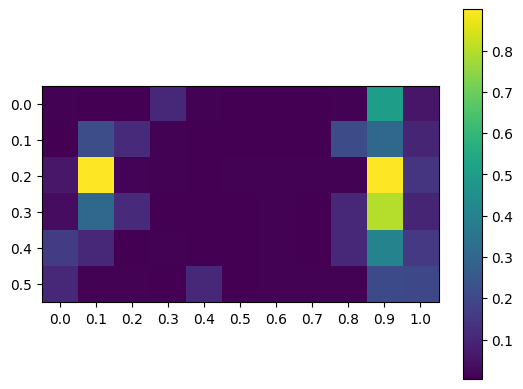

In [17]:
plt.imshow(results.T, interpolation='nearest')
plt.xticks(np.arange(homophily_settings.size), [f'{x:0.1f}' for x in homophily_settings])
plt.yticks(np.arange(consolidation_settings.size), [f'{x:0.1f}' for x in consolidation_settings])
plt.colorbar()
plt.show()